## POS tagging using modified Viterbi

### Data Preparation

In [231]:
#Importing libraries
import nltk
from sklearn.model_selection import train_test_split
import time
import numpy as np, pandas as pd
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import seaborn as sns

In [232]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [233]:
print(nltk_data[:40])

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')], [('Rudolph', 'NOUN'), ('Agnew', 'NOUN'), (',', '.'), ('55', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), ('and', 'CONJ'), ('former', 'ADJ'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Consolidated', 'NOUN'), ('Gold', 'NOUN'), ('Fields', 'NOUN'), ('PLC', 'NOUN'), (',', '.'), ('was', 'VERB'), ('named', 'VERB'), ('*-1', 'X'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('British', 'ADJ'), ('industrial', 'ADJ'), ('

In [234]:
# Splitting into train and validation set
train_set, validation_set = train_test_split(nltk_data,train_size=0.95)

print(len(train_set))
print(len(validation_set))
print(train_set[:40])


3718
196
[[('First', 'NOUN'), ('of', 'ADP'), ('America', 'NOUN'), ('said', 'VERB'), ('0', 'X'), ('some', 'DET'), ('of', 'ADP'), ('the', 'DET'), ('managers', 'NOUN'), ('will', 'VERB'), ('take', 'VERB'), ('other', 'ADJ'), ('jobs', 'NOUN'), ('with', 'ADP'), ('First', 'NOUN'), ('of', 'ADP'), ('America', 'NOUN'), ('.', '.')], [('``', '.'), ('When', 'ADV'), ('we', 'PRON'), ('evaluated', 'VERB'), ('*-2', 'X'), ('raising', 'VERB'), ('our', 'PRON'), ('bid', 'NOUN'), ('*T*-1', 'X'), (',', '.'), ('the', 'DET'), ('risks', 'NOUN'), ('seemed', 'VERB'), ('substantial', 'ADJ'), ('and', 'CONJ'), ('persistent', 'ADJ'), ('over', 'ADP'), ('the', 'DET'), ('next', 'ADJ'), ('five', 'NUM'), ('years', 'NOUN'), (',', '.'), ('and', 'CONJ'), ('the', 'DET'), ('rewards', 'NOUN'), ('seemed', 'VERB'), ('a', 'DET'), ('long', 'ADJ'), ('way', 'NOUN'), ('out', 'ADP'), ('.', '.')], [('All', 'DET'), ('of', 'ADP'), ('this', 'DET'), ('must', 'VERB'), ('have', 'VERB'), ('been', 'VERB'), ('enormously', 'ADV'), ('frustrating', 

In [235]:
# Getting list of tagged words
train_tagged_words = [tup for sent in train_set for tup in sent]
len(train_tagged_words)

95759

In [236]:
train_tagged_words[:5]

[('First', 'NOUN'),
 ('of', 'ADP'),
 ('America', 'NOUN'),
 ('said', 'VERB'),
 ('0', 'X')]

In [237]:
# number of tags
T = set([pair[1] for pair in train_tagged_words])
len(T)

12

In [238]:
print(T, end=',')

{'ADP', 'DET', 'NUM', 'X', 'ADJ', 'PRT', 'ADV', 'CONJ', 'VERB', 'PRON', 'NOUN', '.'},

In [239]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [240]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [241]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))

In [242]:
tags_df

,ADP,DET,NUM,X,ADJ,PRT,ADV,CONJ,VERB,PRON,NOUN,.
ADP,0.016663,0.325892,0.062166,0.034822,0.105747,0.001282,0.013031,0.000748,0.008332,0.069323,0.323115,0.038881
DET,0.009611,0.005406,0.021985,0.045891,0.205310,0.000240,0.012854,0.000481,0.038803,0.003724,0.638155,0.017540
NUM,0.035414,0.003301,0.181573,0.209784,0.034814,0.025210,0.003001,0.013806,0.018307,0.001501,0.358343,0.114946
X,0.144494,0.054901,0.002864,0.074793,0.016868,0.185073,0.025780,0.010821,0.206079,0.054424,0.062062,0.161840
ADJ,0.077689,0.004244,0.020891,0.021054,0.067896,0.011262,0.004733,0.016811,0.012078,0.000653,0.698711,0.063979
PRT,0.018985,0.102455,0.055646,0.013421,0.085434,0.001637,0.010475,0.002291,0.402946,0.017021,0.248445,0.041244
ADV,0.117686,0.069149,0.030253,0.022939,0.130652,0.014960,0.080785,0.006316,0.346410,0.014960,0.031915,0.133976
CONJ,0.053023,0.118140,0.041860,0.008837,0.119535,0.005116,0.053023,0.000465,0.155349,0.059535,0.349767,0.035349
VERB,0.091339,0.135768,0.022563,0.217648,0.065907,0.030937,0.081724,0.005428,0.169419,0.035202,0.109483,0.034582
PRON,0.021622,0.009653,0.007722,0.094595,0.074517,0.012741,0.034363,0.005019,0.481081,0.008108,0.210425,0.040154


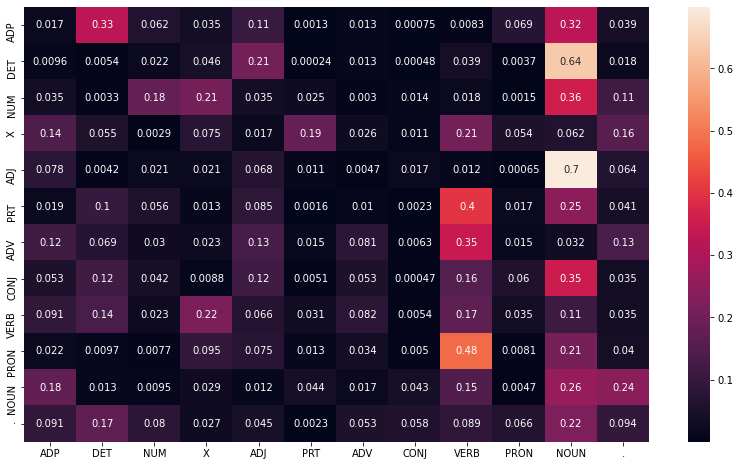

In [243]:
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(14, 8))
sns.heatmap(tags_df, annot = True)
plt.show()

In [244]:
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

In [245]:
accuracy_metrics={}

### Build the vanilla Viterbi based POS tagger

In [246]:
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [247]:
# list of untagged words
test_tagged_words = [tup[0] for sent in validation_set for tup in sent]
len(test_tagged_words)

4917

In [248]:
test_tagged_words

['That',
 'proposal',
 'had',
 'been',
 'hailed',
 '*-1',
 'by',
 'environmentalists',
 'but',
 'despised',
 '*-1',
 'by',
 'utilities',
 'because',
 'they',
 'feared',
 '0',
 'it',
 'would',
 'limit',
 'their',
 'growth',
 '.',
 'As',
 'a',
 'part',
 'of',
 'overall',
 'efforts',
 '*',
 'to',
 'reduce',
 'spending',
 ',',
 'Congress',
 'cut',
 'by',
 '$',
 '30',
 'million',
 '*U*',
 'the',
 'Bush',
 'administration',
 "'s",
 'request',
 'for',
 'antitrust',
 'enforcement',
 'for',
 'fiscal',
 '1990',
 ',',
 'which',
 '*T*-81',
 'began',
 'Oct.',
 '1',
 '.',
 'Neither',
 'First',
 'Securities',
 ',',
 'of',
 'Beverly',
 'Hills',
 ',',
 'nor',
 'Mr.',
 'Vargas',
 'could',
 'be',
 'reached',
 '*-153',
 'for',
 'comment',
 '.',
 'Without',
 '*-1',
 'admitting',
 'or',
 'denying',
 'wrongdoing',
 ',',
 'they',
 'consented',
 'to',
 'findings',
 'of',
 'violations',
 'of',
 'escrow',
 'and',
 'record-keeping',
 'rules',
 '.',
 'In',
 'the',
 'U.S.',
 'over-the-counter',
 'market',
 ',',
 'A

In [249]:
validation_set

[[('That', 'DET'),
  ('proposal', 'NOUN'),
  ('had', 'VERB'),
  ('been', 'VERB'),
  ('hailed', 'VERB'),
  ('*-1', 'X'),
  ('by', 'ADP'),
  ('environmentalists', 'NOUN'),
  ('but', 'CONJ'),
  ('despised', 'VERB'),
  ('*-1', 'X'),
  ('by', 'ADP'),
  ('utilities', 'NOUN'),
  ('because', 'ADP'),
  ('they', 'PRON'),
  ('feared', 'VERB'),
  ('0', 'X'),
  ('it', 'PRON'),
  ('would', 'VERB'),
  ('limit', 'VERB'),
  ('their', 'PRON'),
  ('growth', 'NOUN'),
  ('.', '.')],
 [('As', 'ADP'),
  ('a', 'DET'),
  ('part', 'NOUN'),
  ('of', 'ADP'),
  ('overall', 'ADJ'),
  ('efforts', 'NOUN'),
  ('*', 'X'),
  ('to', 'PRT'),
  ('reduce', 'VERB'),
  ('spending', 'NOUN'),
  (',', '.'),
  ('Congress', 'NOUN'),
  ('cut', 'VERB'),
  ('by', 'ADP'),
  ('$', '.'),
  ('30', 'NUM'),
  ('million', 'NUM'),
  ('*U*', 'X'),
  ('the', 'DET'),
  ('Bush', 'NOUN'),
  ('administration', 'NOUN'),
  ("'s", 'PRT'),
  ('request', 'NOUN'),
  ('for', 'ADP'),
  ('antitrust', 'ADJ'),
  ('enforcement', 'NOUN'),
  ('for', 'ADP'),
  (

### Evaluation on validation set

In [250]:
# tagging the words in validation set using vanilla viterbi algorithm
start = time.time()
tagged_seq = Viterbi(test_tagged_words)
end = time.time()
difference = end-start

In [251]:
print("Time taken in seconds: ", difference/60)
print(tagged_seq)


Time taken in seconds:  26.27406980593999
[('That', 'DET'), ('proposal', 'NOUN'), ('had', 'VERB'), ('been', 'VERB'), ('hailed', 'ADP'), ('*-1', 'X'), ('by', 'ADP'), ('environmentalists', 'ADP'), ('but', 'CONJ'), ('despised', 'ADP'), ('*-1', 'X'), ('by', 'ADP'), ('utilities', 'NOUN'), ('because', 'ADP'), ('they', 'PRON'), ('feared', 'VERB'), ('0', 'X'), ('it', 'PRON'), ('would', 'VERB'), ('limit', 'NOUN'), ('their', 'PRON'), ('growth', 'NOUN'), ('.', '.'), ('As', 'ADP'), ('a', 'DET'), ('part', 'NOUN'), ('of', 'ADP'), ('overall', 'ADJ'), ('efforts', 'NOUN'), ('*', 'X'), ('to', 'PRT'), ('reduce', 'VERB'), ('spending', 'NOUN'), (',', '.'), ('Congress', 'NOUN'), ('cut', 'VERB'), ('by', 'ADP'), ('$', '.'), ('30', 'NUM'), ('million', 'NUM'), ('*U*', 'X'), ('the', 'DET'), ('Bush', 'NOUN'), ('administration', 'NOUN'), ("'s", 'PRT'), ('request', 'NOUN'), ('for', 'ADP'), ('antitrust', 'ADJ'), ('enforcement', 'NOUN'), ('for', 'ADP'), ('fiscal', 'ADJ'), ('1990', 'NUM'), (',', '.'), ('which', 'DET')

In [252]:
len(tagged_seq)

4917

In [253]:
tagged_seq[:10]

[('That', 'DET'),
 ('proposal', 'NOUN'),
 ('had', 'VERB'),
 ('been', 'VERB'),
 ('hailed', 'ADP'),
 ('*-1', 'X'),
 ('by', 'ADP'),
 ('environmentalists', 'ADP'),
 ('but', 'CONJ'),
 ('despised', 'ADP')]

In [254]:
validation_set[:2]

[[('That', 'DET'),
  ('proposal', 'NOUN'),
  ('had', 'VERB'),
  ('been', 'VERB'),
  ('hailed', 'VERB'),
  ('*-1', 'X'),
  ('by', 'ADP'),
  ('environmentalists', 'NOUN'),
  ('but', 'CONJ'),
  ('despised', 'VERB'),
  ('*-1', 'X'),
  ('by', 'ADP'),
  ('utilities', 'NOUN'),
  ('because', 'ADP'),
  ('they', 'PRON'),
  ('feared', 'VERB'),
  ('0', 'X'),
  ('it', 'PRON'),
  ('would', 'VERB'),
  ('limit', 'VERB'),
  ('their', 'PRON'),
  ('growth', 'NOUN'),
  ('.', '.')],
 [('As', 'ADP'),
  ('a', 'DET'),
  ('part', 'NOUN'),
  ('of', 'ADP'),
  ('overall', 'ADJ'),
  ('efforts', 'NOUN'),
  ('*', 'X'),
  ('to', 'PRT'),
  ('reduce', 'VERB'),
  ('spending', 'NOUN'),
  (',', '.'),
  ('Congress', 'NOUN'),
  ('cut', 'VERB'),
  ('by', 'ADP'),
  ('$', '.'),
  ('30', 'NUM'),
  ('million', 'NUM'),
  ('*U*', 'X'),
  ('the', 'DET'),
  ('Bush', 'NOUN'),
  ('administration', 'NOUN'),
  ("'s", 'PRT'),
  ('request', 'NOUN'),
  ('for', 'ADP'),
  ('antitrust', 'ADJ'),
  ('enforcement', 'NOUN'),
  ('for', 'ADP'),
  (

In [255]:
#getting the tupes from validation set to check the accuracy of the model
test_run_base1 = [tup for sent in validation_set for tup in sent]

In [256]:
test_run_base1[:10]

[('That', 'DET'),
 ('proposal', 'NOUN'),
 ('had', 'VERB'),
 ('been', 'VERB'),
 ('hailed', 'VERB'),
 ('*-1', 'X'),
 ('by', 'ADP'),
 ('environmentalists', 'NOUN'),
 ('but', 'CONJ'),
 ('despised', 'VERB')]

In [257]:
check = [i for i, j in zip(tagged_seq, test_run_base1) if i == j] 

In [258]:
len(check)

4470

#### Evaluating tagging accuracy

In [259]:
#Accuracy of vanilla viterbi model
accuracy=len(check)/len(tagged_seq)

In [260]:
accuracy_metrics['Viterbi Vanilla']=(len(check)/len(tagged_seq))*100
accuracy_metrics

{'Viterbi Vanilla': 90.9090909090909}

### Sample Test Sentences 

In [314]:
## testing on the sample sentences
test_case_sentences="Android is a mobile operating system developed by Google.Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013. Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.Twitter is an online news and social networking service on which users post and interact with messages known as tweets.Before entering politics, Donald Trump was a domineering businessman and a television personality.The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.Show me the cheapest round trips from Dallas to Atlanta.I would like to see flights from Denver to Philadelphia.Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.NASA invited social media users to experience the launch of ICESAT-2 Satellite."
test_words = word_tokenize(test_case_sentences)

In [261]:
start=time.time()
tagged_seq2=Viterbi(test_words)
end=time.time()
difference=(end-start)/60

In [262]:
print(tagged_seq2)
print(difference)

[('Android', 'ADP'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google.Android', 'ADP'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'ADP'), ('worldwide', 'ADP'), ('on', 'ADP'), ('smartphones', 'ADP'), ('since', 'ADP'), ('2011', 'ADP'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'ADP'), ('.', '.'), ('Google', 'ADP'), ('and', 'CONJ'), ('Twitter', 'ADP'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'ADP'), ('that', 'DET'), ('gave', 'VERB'), ('Google', 'ADP'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'ADP'), ("'s", 'PRT'), ('firehose.Twitter', 'ADP'), ('is', 'VERB'), ('an', 'DET'), ('online', 'ADP'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'), ('users', 'NOUN'), ('post', 'NOUN'), ('and', 'CONJ'), ('intera

### Solve the problem of unknown words

In [265]:
#checking which were the non matching tags for the words in validation set with vanilla viterbi solution
check1 = [i for i, j in zip(tagged_seq, test_run_base1) if i != j]
check1

[('hailed', 'ADP'),
 ('environmentalists', 'ADP'),
 ('despised', 'ADP'),
 ('limit', 'NOUN'),
 ('*T*-81', 'ADP'),
 ('*-153', 'ADP'),
 ('record-keeping', 'NOUN'),
 ('American', 'NOUN'),
 ('43.875', 'ADP'),
 ('winners', 'ADP'),
 ('Shokubai', 'ADP'),
 ('up', 'ADV'),
 ('2,410', 'ADP'),
 ('Powers', 'ADP'),
 ('deceptive', 'ADP'),
 ('contribution', 'ADP'),
 ('goverment', 'ADP'),
 ('counts', 'NOUN'),
 ('counts', 'NOUN'),
 ('no', 'DET'),
 ('off', 'PRT'),
 ('strengthened', 'ADP'),
 ('Keith', 'ADP'),
 ('genuine', 'ADP'),
 ('touchy', 'ADP'),
 ("'s", 'PRT'),
 ('out', 'PRT'),
 ('waited', 'ADP'),
 ('sneaked', 'ADP'),
 ('climb', 'ADP'),
 ('566.54', 'ADP'),
 ('28.53', 'ADP'),
 ('sense', 'NOUN'),
 ('reluctant', 'ADP'),
 ('stick', 'ADP'),
 ('necks', 'ADP'),
 ('out', 'ADP'),
 ('out', 'PRT'),
 ('Eakle', 'ADP'),
 ('Eakle', 'ADP'),
 ('view', 'NOUN'),
 ('so', 'ADV'),
 ('Olsen', 'ADP'),
 ('Encouraging', 'ADP'),
 ('investing', 'VERB'),
 ('summoned', 'ADP'),
 ('thin-lipped', 'ADP'),
 ('Isabelle', 'ADP'),
 ('Huppe

In [266]:
print(T, end=',')
print(len(T))

{'ADP', 'DET', 'NUM', 'X', 'ADJ', 'PRT', 'ADV', 'CONJ', 'VERB', 'PRON', 'NOUN', '.'},12


In [269]:
#getting the frequency of the tags which is correctly tagged
d1={}
for t in T:
    d1[t]=0
for tup in check:
    d1[tup[1]]=d1[tup[1]]+1
print(d1,end='')

{'ADP': 482, 'DET': 393, 'NUM': 179, 'X': 317, 'ADJ': 202, 'PRT': 151, 'ADV': 135, 'CONJ': 115, 'VERB': 573, 'PRON': 147, 'NOUN': 1191, '.': 585}

### NOUN seems to be the most frequent tag. Will use it for modification in viterbi to tag unknown words.

In [270]:
# for key,word in enumerate(test_run_base1):
#     print(key,word)

### Modification 1 in viterbi algorithm

#####  replace all unknown words by NOUN tag (Noun being the most common tag)

In [271]:
def Viterbi_modification1(test_words, train_bag=train_tagged_words):
    tagged_seq1=Viterbi(test_words)
    t_words = list(set([pair[0] for pair in train_bag]))
    
    words= [pair[0] for pair in tagged_seq1]
    tags = [pair[1] for pair in tagged_seq1]
    
    for key, word in enumerate(words):
        if word not in t_words:
            tags[key]='NOUN'
    return list(zip(words,tags))

### Evaluation on validation set

In [272]:
#validating the modified viterbi algorithm on validation set
validation_viterbi_modification1 = Viterbi_modification1(test_tagged_words)

#### Evaluating tagging accuracy

In [273]:
#accuracy of the model
check_modification1 = [i for i,j in zip(validation_viterbi_modification1,test_run_base1) if i==j]
len(check_modification1)/len(validation_viterbi_modification1)

0.9402074435631482

In [274]:
accuracy_metrics['Viterbi_modification_1']=(len(check_modification1)/len(validation_viterbi_modification1))*100
accuracy_metrics

{'Viterbi Vanilla': 90.9090909090909,
 'Viterbi_modification_1': 94.02074435631482}

#### testing on the sample setences

In [275]:

test_case_sentences="Android is a mobile operating system developed by Google. Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013. Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose. Twitter is an online news and social networking service on which users post and interact with messages known as tweets. Before entering politics, Donald Trump was a domineering businessman and a television personality. The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years. This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe. Show me the cheapest round trips from Dallas to Atlanta. I would like to see flights from Denver to Philadelphia. Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco. NASA invited social media users to experience the launch of ICESAT-2 Satellite."
test_words = word_tokenize(test_case_sentences)

start=time.time()
tagged_seq3=Viterbi_modification1(test_words)
end=time.time()
difference=(end-start)/60

In [276]:
print(tagged_seq3)
print(difference)

[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.'), ('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'NOUN'), ('since', 'ADP'), ('2011', 'NOUN'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NOUN'), ('.', '.'), ('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'NOUN'), ('that', 'DET'), ('gave', 'VERB'), ('Google', 'NOUN'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'NOUN'), ("'s", 'PRT'), ('firehose', 'NOUN'), ('.', '.'), ('Twitter', 'NOUN'), ('is', 'VERB'), ('an', 'DET'), ('online', 'NOUN'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET')

### Modification 2 in viterbi algorithm

#### Replace
#### 1. all unknown words with first letter capital/all letters capital are tagged as noun, 
#### 2. numbers are tagged as NUM
#### 3. words ending with '-ous' as ADJ and rest as NOUN

In [277]:
def Viterbi_modification2(test_words,train_bag=train_tagged_words):
    tagged_seq=Viterbi(test_words)
    t_words = list(set([pair[0] for pair in train_bag]))
    
    words= [pair[0] for pair in tagged_seq]
    Viterbi_tags2 = [pair[1] for pair in tagged_seq]
    
    for key, word in enumerate(words):
        if word not in t_words:
            ## word ending with -ous as ADJ
            if word[-3:] == 'ous':
                Viterbi_tags2[key] = 'ADJ'
            elif (word.isdigit() == True or word[:-2].isdigit() == True):
                Viterbi_tags2[key] = 'NUM'
            elif word.upper() == word:
                Viterbi_tags2[key] = 'NOUN'
            elif (word[0].upper()== word[0]):
                Viterbi_tags2[key] = 'NOUN'
            else:
                Viterbi_tags2[key]='NOUN'
    return list(zip(words,Viterbi_tags2))

### Evaluation on validation set

In [278]:
# testing the modified viterbi algorithm on validation set
validation_viterbi_modification2 = Viterbi_modification2(test_tagged_words)

#### Evaluating tagging accuracy

In [279]:
#accuracy of the model
check_modification2 = [i for i,j in zip(validation_viterbi_modification2,test_run_base1) if i==j]
len(check_modification2)/len(validation_viterbi_modification2)

0.942851332113077

In [280]:
accuracy_metrics['Viterbi_modification_2']=(len(check_modification2)/len(validation_viterbi_modification2))*100
accuracy_metrics

{'Viterbi Vanilla': 90.9090909090909,
 'Viterbi_modification_1': 94.02074435631482,
 'Viterbi_modification_2': 94.28513321130771}

#### testing on the sample setences

In [281]:
# testing the model on the sample sentences provided
start=time.time()
tagged_seq4=Viterbi_modification2(test_words)
end=time.time()
difference=(end-start)/60


In [282]:
print(tagged_seq4)
print(difference)

[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.'), ('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'NOUN'), ('since', 'ADP'), ('2011', 'NUM'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NUM'), ('.', '.'), ('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'NUM'), ('that', 'DET'), ('gave', 'VERB'), ('Google', 'NOUN'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'NOUN'), ("'s", 'PRT'), ('firehose', 'NOUN'), ('.', '.'), ('Twitter', 'NOUN'), ('is', 'VERB'), ('an', 'DET'), ('online', 'NOUN'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'), (

### Modification 3

#### state probability is dependent only on transition probability when the word is first word in the sentence

In [283]:
def Viterbi_modification3(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    V = list(set([pair[0] for pair in train_bag]))
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            
            if word in V:
                state_probability = emission_p * transition_p
            else:
                state_probability = transition_p
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

### Evaluation on validation set

In [284]:
# checking the model on validation set
start=time.time()
validation_viterbi_modification3 = Viterbi_modification3(test_tagged_words)
end=time.time()
print(end-start)

1307.5219876766205


#### Evaluating tagging accuracy

In [285]:
# accuracy of the modified model
check_modification3 = [i for i,j in zip(validation_viterbi_modification3,test_run_base1) if i==j]
len(check_modification2)/len(validation_viterbi_modification3)

0.942851332113077

In [286]:
accuracy_metrics['Viterbi_modification_3']=(len(check_modification2)/len(validation_viterbi_modification3))*100
accuracy_metrics

{'Viterbi Vanilla': 90.9090909090909,
 'Viterbi_modification_1': 94.02074435631482,
 'Viterbi_modification_2': 94.28513321130771,
 'Viterbi_modification_3': 94.28513321130771}

#### testing on the sample setences

In [287]:
# testing the model on sample sentences
start=time.time()
tagged_seq5=Viterbi_modification3(test_words)
end=time.time()
difference=(end-start)/60

In [288]:
print(tagged_seq5)
print(difference)

[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'DET'), ('.', '.'), ('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'DET'), ('since', 'ADP'), ('2011', 'DET'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'DET'), ('.', '.'), ('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'DET'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'X'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'VERB'), ("'s", 'PRT'), ('firehose', 'VERB'), ('.', '.'), ('Twitter', 'NOUN'), ('is', 'VERB'), ('an', 'DET'), ('online', 'NOUN'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'), ('user

### Modification 4

#### A bigram tagger backed off by a rule based tagger.

In [291]:
def bigram_tagger(word, train_set = train_set):
    
    patterns = [
    (r'[aA-zZ]+(ed|ing|es)$', 'VERB'),
    (r'.*ly$', 'ADV'),
    (r'^([0-9]|[aA-zZ])+\-[aA-zZ]*$','ADJ'),
    (r'.*able$', 'ADJ'), 
    (r'.*ful$', 'ADJ'),
    (r'.*ous$', 'ADJ'),
    (r'^[aA-zZ].*[0-9]+','NOUN'),  
    (r'.*ness$', 'NOUN'),
    (r'.*\'s$', 'NOUN'),            
    (r'.*s$', 'NOUN'),         
    (r'^(0|([*|-|$].*))','X'),
    (r'.*ould$', 'X'),
    (r'(The|the|A|a|An|an|That|that|This|this|Those|those|These|these)$', 'DET'),
    (r'[0-9].?[,\/]?[0-9]*','NUM'),
    (r'.*', 'NOUN')
    ]

    regex_based_tagger = nltk.RegexpTagger(patterns)

    # bigram backed up by the regex tagger
    bigram_regex_tagger = nltk.BigramTagger(train_set, backoff = regex_based_tagger)
    return bigram_regex_tagger.tag_sents([[(word)]])

In [292]:

# Lexicon (or Bigram tagger)

def Viterbi_modification4(words,train_bag=train_tagged_words):
    
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    tokens = list(set([pair[0] for pair in train_bag]))
    
    for key, word in enumerate(words):
        # unknown words from bigram tagger
        if word not in tokens:
            word_tag=bigram_tagger(word)
            for sent in word_tag:
                for tup in sent:
                    state.append(tup[1])
                    #print(word," :unknown word: ",tup[1]," : tag")
               
        else:            
            p = [] 
            for tag in T:
                if key == 0:
                    transition_p = tags_df.loc['.', tag]
                else:
                    transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
                emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
                state_probability = emission_p * transition_p    
                p.append(state_probability)
            
            pmax = max(p)
            # getting state for which probability is maximum
            state_max = T[p.index(pmax)] 
            state.append(state_max)
            
    return list(zip(words,state))

### Evaluation on validation set

In [293]:
# checking the model on validation set
start=time.time()
validation_viterbi_modification4 = Viterbi_modification4(test_tagged_words)
end=time.time()
print(end-start)

1950.3604052066803


In [294]:
3461/60

57.68333333333333

#### Evaluating tagging accuracy

In [295]:
# accuracy of the modified model
check_modification4 = [i for i,j in zip(validation_viterbi_modification4,test_run_base1) if i==j]
len(check_modification4)/len(validation_viterbi_modification4)

0.9591214154972544

In [318]:
accuracy_metrics['Viterbi_modification_4']=(len(check_modification4)/len(validation_viterbi_modification4))*100
accuracy_metrics

{'Viterbi Vanilla': 90.9090909090909,
 'Viterbi_modification_1': 94.02074435631482,
 'Viterbi_modification_2': 94.28513321130771,
 'Viterbi_modification_3': 94.28513321130771,
 'Viterbi_modification_4': 95.91214154972543}

#### testing on the sample setences

In [319]:
# testing the model on sample sentences
start=time.time()
tagged_seq6=Viterbi_modification4(test_words)
end=time.time()
difference=(end-start)/60

In [320]:
print(tagged_seq6)
print(difference)

[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google.Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'VERB'), ('since', 'ADP'), ('2011', 'NUM'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NUM'), ('.', '.'), ('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'NUM'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'NOUN'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'NOUN'), ("'s", 'PRT'), ('firehose.Twitter', 'NOUN'), ('is', 'VERB'), ('an', 'DET'), ('online', 'NOUN'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'), ('users', 'NOUN'), ('post', 'NOUN'), ('and', 'CONJ'

### Modification 5

#### Bigram tagger with unigram tagger as backoff with Default Tagger as backoff

In [296]:
def bigram_tagger1(word,train_set = train_set):
    default = nltk.DefaultTagger('NOUN')
    unigram = nltk.UnigramTagger(train_set, backoff=default)
    bigram = nltk.BigramTagger(train_set, backoff=unigram)
    return bigram.tag_sents([[(word)]])

In [297]:
def Viterbi_modified5(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    tokens = list(set([pair[0] for pair in train_bag]))
    
    for key, word in enumerate(words):
        # unknown words from trigram taggr
        if word not in tokens:
            word_tag=bigram_tagger1(word)
            for sent in word_tag:
                for tup in sent:
                    state.append(tup[1])
                    #print(word," :unknown word: ",tup[1]," : tag")
        # rest remains same            
        else:            
            p = [] 
            for tag in T:
                if key == 0:
                    transition_p = tags_df.loc['.', tag]
                else:
                    transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
                emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
                state_probability = emission_p * transition_p    
                p.append(state_probability)
            
            pmax = max(p)
            # getting state for which probability is maximum
            state_max = T[p.index(pmax)] 
            state.append(state_max)
            
    return list(zip(words, state))

### Evaluation on validation set

In [298]:
# checking the model on validation set
start=time.time()
validation_viterbi_modification5 = Viterbi_modified5(test_tagged_words)
end=time.time()
print(end-start)

1708.3541502952576


In [299]:
1365/60

22.75

#### Evaluating tagging accuracy

In [300]:
# accuracy of the modified model
check_modification5 = [i for i,j in zip(validation_viterbi_modification5,test_run_base1) if i==j]
len(check_modification5)/len(validation_viterbi_modification5)

0.9408175716900549

In [321]:
accuracy_metrics['Viterbi_modification_5']=(len(check_modification5)/len(validation_viterbi_modification5))*100
accuracy_metrics

{'Viterbi Vanilla': 90.9090909090909,
 'Viterbi_modification_1': 94.02074435631482,
 'Viterbi_modification_2': 94.28513321130771,
 'Viterbi_modification_3': 94.28513321130771,
 'Viterbi_modification_4': 95.91214154972543,
 'Viterbi_modification_5': 94.08175716900548}

#### testing on the sample setences

In [303]:
# testing the model on sample sentences
start=time.time()
tagged_seq6=Viterbi_modified5(test_words)
end=time.time()
difference=(end-start)/60

In [304]:
print(difference)
print(tagged_seq6)

1.6027113835016886
[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.'), ('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'NOUN'), ('since', 'ADP'), ('2011', 'NOUN'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NOUN'), ('.', '.'), ('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'NOUN'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'NOUN'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'NOUN'), ("'s", 'PRT'), ('firehose', 'NOUN'), ('.', '.'), ('Twitter', 'NOUN'), ('is', 'VERB'), ('an', 'DET'), ('online', 'NOUN'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'

### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

In [322]:
df1=pd.DataFrame(accuracy_metrics.items(),columns=['Model','Accuracy'])
df1

,Model,Accuracy
0,Viterbi Vanilla,90.909091
1,Viterbi_modification_1,94.020744
2,Viterbi_modification_2,94.285133
3,Viterbi_modification_3,94.285133
4,Viterbi_modification_4,95.912142
5,Viterbi_modification_5,94.081757


### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

In [306]:
## Testing with vanilla viterbi
sentence_test_1 = "Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose."
words = word_tokenize(sentence_test_1)
tagged_seq_1 = Viterbi(words)
print(tagged_seq_1)

[('Google', 'ADP'), ('and', 'CONJ'), ('Twitter', 'ADP'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'ADP'), ('that', 'DET'), ('gave', 'VERB'), ('Google', 'ADP'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'ADP'), ("'s", 'PRT'), ('firehose', 'ADP'), ('.', '.')]


In [323]:
## Testing with  viterbi after modification 4
sentence_test_1 = "Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose."
words = word_tokenize(sentence_test_1)
tagged_seq_1 = Viterbi_modification4(words)
print(tagged_seq_1)

[('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'NUM'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'NOUN'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'NOUN'), ("'s", 'PRT'), ('firehose', 'NOUN'), ('.', '.')]


### In the above example it can be seen that Google, Twitter have been correctly tagged after modification. Also the numeral 2015 is tagged as NUM after modification.

In [309]:
# Testing with vanilla viterbi
sentence2="NASA invited social media users to experience the launch of ICESAT-2 Satellite."
words = word_tokenize(sentence2)
tagged_seq_2 = Viterbi(words)
print(tagged_seq_2)

[('NASA', 'ADP'), ('invited', 'ADP'), ('social', 'ADJ'), ('media', 'NOUN'), ('users', 'NOUN'), ('to', 'PRT'), ('experience', 'NOUN'), ('the', 'DET'), ('launch', 'NOUN'), ('of', 'ADP'), ('ICESAT-2', 'ADP'), ('Satellite', 'ADP'), ('.', '.')]


In [324]:
# Testing with viterbi modification 4
sentence2="NASA invited social media users to experience the launch of ICESAT-2 Satellite."
words = word_tokenize(sentence2)
tagged_seq_2 = Viterbi_modification4(words)
print(tagged_seq_2)

[('NASA', 'NOUN'), ('invited', 'VERB'), ('social', 'ADJ'), ('media', 'NOUN'), ('users', 'NOUN'), ('to', 'PRT'), ('experience', 'NOUN'), ('the', 'DET'), ('launch', 'NOUN'), ('of', 'ADP'), ('ICESAT-2', 'NOUN'), ('Satellite', 'NOUN'), ('.', '.')]


### In the above example, invited has been corrected to VERB after modification. Also the ICESAT-2 has been correctly tagged as NOUN.

In [312]:
#  Testing with vanilla viterbi
sentence3="I would like to see flights from Denver to Philadelphia."
words = word_tokenize(sentence3)
tagged_seq_3 = Viterbi(words)
print(tagged_seq_3)

[('I', 'PRON'), ('would', 'VERB'), ('like', 'ADP'), ('to', 'PRT'), ('see', 'VERB'), ('flights', 'NOUN'), ('from', 'ADP'), ('Denver', 'NOUN'), ('to', 'PRT'), ('Philadelphia', 'NOUN'), ('.', '.')]


In [325]:
#  Testing with viterbi modification 4
sentence3="I would like to see flights from Denver to Philadelphia."
words = word_tokenize(sentence3)
tagged_seq_3 = Viterbi_modification4(words)
print(tagged_seq_3)

[('I', 'PRON'), ('would', 'VERB'), ('like', 'ADP'), ('to', 'PRT'), ('see', 'VERB'), ('flights', 'NOUN'), ('from', 'ADP'), ('Denver', 'NOUN'), ('to', 'PRT'), ('Philadelphia', 'NOUN'), ('.', '.')]


### The above example is simple where the words have been tagged correctly even by the vanilla viterbi algorithm.